<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/NLP-Projects/blob/main/Text%20Generation%20-%20Gutenberg%20Dataset%20-%20LSTM%20Model/Text_Generation_Gutenberg_Dataset_(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libs & Setup Project

In [ ]:
# !pip install -q tensorflow

In [ ]:
# Import Libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import requests
import re

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Setup logger
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s-%(levelname)s-%(name)s-%(message)s',
    handlers=[
        logging.FileHandler('app.log'),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)
logger.info("Logger started...")

# Import Dataset & Preprocessing

In [ ]:
# Download dataset
try:
    logger.info("Downloading dataset...")
    url = "https://www.gutenberg.org/files/11/11-0.txt"
    response = requests.get(url)
    text = response.text
except Exception as e:
    logger.error(f"Error downloading dataset: {e}")
    raise

In [ ]:
# Preprocessing

# Clean text: keep only valid characters (letters, numbers, common punctuation)
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove invalid characters, keep alphanumeric and common punctuation
    text = re.sub(r'[^\w\s.,!?-]', '', text)
    return text

try:
    logger.info("Starting preprocessing...")
    text = clean_text(text)

    # Create vocabulary: all unique characters
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    print(f"Vocabulary Size: {vocab_size}")
    logger.info(f"Vocabulary Size: {vocab_size}")

    # Create mappings: character to index and index to character
    chars_to_idx = {c: i for i, c in enumerate(chars)}
    idx_to_chars = {i: c for i, c in enumerate(chars)}

    # Debug: ensure idx_to_chars covers all indices from 0 to vocab_size-1
    for i in range(vocab_size):
        if i not in idx_to_chars:
            logger.error(f"Index {i} missing in idx_to_chars")
            raise ValueError(f"Index {i} missing in idx_to_chars")
except Exception as e:
    logger.error(f"Error during preprocessing: {e}")
    raise

Vocabulary Size: 39


In [ ]:
# Creating Sequences
try:
    SEQ_LEN = 40  # Sequence length (input_length for Embedding)
    logger.info("Creating sequences...")

    X, y = [], []
    for i in range(0, len(text) - SEQ_LEN, 1):
        seq_in = text[i:i + SEQ_LEN]  # SEQ_LEN characters
        seq_out = text[i + SEQ_LEN]   # Next character
        X.append([chars_to_idx[c] for c in seq_in])
        y.append(chars_to_idx[seq_out])
        # Log first few sequences for debugging
        if i < 3:
            logger.info(f"Sequence: {seq_in} -> {seq_out}")

    # Convert to arrays
    X = np.array(X)
    y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

    # Check shapes
    print(f"X Shape: {X.shape}, y Shape: {y.shape}")
    logger.info(f"X Shape: {X.shape}, y Shape: {y.shape}")
    # Dimensions:
    # X: [num_sequences, SEQ_LEN]
    # - num_sequences = len(text) - SEQ_LEN
    # - SEQ_LEN=40 (input sequence length)
    # y: [num_sequences, vocab_size]
    # - vocab_size: number of unique characters (e.g., 60)
except Exception as e:
    logger.error(f"Error creating sequences: {e}")
    raise

X Shape: (144177, 40), y Shape: (144177, 39)


# Define Model

In [ ]:
# Model
model = Sequential([
    Embedding(vocab_size, 64, input_length=SEQ_LEN, input_shape=(SEQ_LEN,)),
    LSTM(128, return_sequences=True, recurrent_dropout=0.2),
    Dropout(0.2),
    LSTM(128, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])

# Define optimizers & loss func
optimizer = tf.keras.optimizers.Adam(clipnorm=1.0)
loss = tf.keras.losses.CategoricalCrossentropy()

# Compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

# Check Summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 40, 64)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 40, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 39)             │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,927 (929.40 KB)

 Trainable params: 237,927 (929.40 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=5,
    min_lr = 0.001
)

# Define Check points
checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    save_best_only=True,
)

In [ ]:
# Train the Model
history = model.fit(
    X, y,
    epochs=50,
    batch_size=256,
    callbacks=[reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 128s 216ms/step - accuracy: 0.2116 - loss: 2.8848 - learning_rate: 0.0010
Epoch 2/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 141s 216ms/step - accuracy: 0.3802 - loss: 2.1356 - learning_rate: 0.0010
Epoch 3/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 143s 217ms/step - accuracy: 0.4266 - loss: 1.9672 - learning_rate: 0.0010
Epoch 4/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 141s 216ms/step - accuracy: 0.4579 - loss: 1.8534 - learning_rate: 0.0010
Epoch 5/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 142s 216ms/step - accuracy: 0.4778 - loss: 1.7772 - learning_rate: 0.0010
Epoch 6/50
564/564 ━━━━━━━━━━━━━━━━━━━━ 122s 216ms/step - accuracy: 0.4931 - loss: 1.7168 - learning_rate: 0.0010
Epoch 7/50
225/564 ━━━━━━━━━━━━━━━━━━━━ 1:12 215ms/step - accuracy: 0.5033 - loss: 1.6727

# Loss & Accuracy Plot

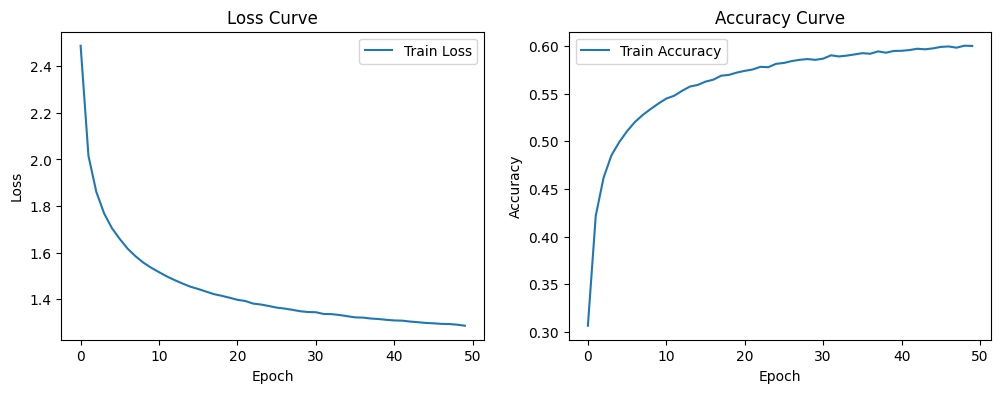

In [ ]:
# Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.title("Loss Curve")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title("Accuracy Curve")
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Generating Sample Text

In [ ]:
# Function to generate text
def generate_text(seed_text, length=200, temperature=0.7):
    generated = seed_text
    for _ in range(length):
        x_pred = np.array([[chars_to_idx.get(c, 0) for c in generated[-SEQ_LEN:]]])
        preds = model.predict(x_pred, verbose=0)[0]
        # set temperature
        preds = np.log(preds + 1e-10) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        next_idx = np.random.choice(range(vocab_size), p=preds)
        next_char = idx_to_chars[next_idx]
        generated += next_char
    return generated


seed = text[1000:1000 + SEQ_LEN]  # انتخاب یه بخش از متن به‌عنوان seed
for temp in [0.2, 0.7, 1.2]:
    print(f"\nGenerated text with temperature={temp}:")
    print(generate_text(seed, length=300, temperature=temp))